# First CNN model (test)

## Import

In [1]:
import random
import os
from itertools import count
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-08-28 23:17:51.990228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-28 23:17:51.994537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-28 23:17:51.994848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Config variables

In [3]:
DATASET_PATH = '../dataset/'
DATASET_IMAGES_PATH = {folder: os.path.join(DATASET_PATH, folder) for folder in os.listdir(DATASET_PATH)}
DATASET_IMAGES_FLAG = cv2.IMREAD_GRAYSCALE
DATASET_IMAGES_SHAPE = (45, 45, 1)

TARGET_DECODER = {i: target for i, target in enumerate(sorted(DATASET_IMAGES_PATH))}
TARGET_ENCODER = dict((value, key) for key, value in TARGET_DECODER.items())
TARGETS_SIZES = {name: len(os.listdir(os.path.join(DATASET_PATH, name))) for name in os.listdir(DATASET_PATH)}

DATASET_LEN = 3068 * len(DATASET_IMAGES_PATH)  # lenght of '8' folder

FIT_RANDOM_STATE = 101
FIT_TEST_SIZE = 0.20

In [4]:
random.seed(FIT_RANDOM_STATE)

In [5]:
list(sorted(TARGETS_SIZES.items(), key=lambda x: x[1]))

[('div', 868),
 ('7', 2909),
 ('8', 3068),
 ('6', 3118),
 ('times', 3251),
 ('5', 3545),
 ('9', 3737),
 ('0', 6914),
 ('4', 7396),
 ('3', 10909),
 ('parenthesis-opened', 14294),
 ('parenthesis-closed', 14355),
 ('plus', 25112),
 ('2', 26141),
 ('1', 26520),
 ('minus', 33997)]

## Processing functions

In [6]:
def pre_processing(image: np.ndarray) -> np.ndarray:
    image = cv2.resize(image, DATASET_IMAGES_SHAPE[:2])
    image = image[:, :, np.newaxis]
    image = image / 255.
    return image

In [7]:
def get_image_from_file(file_path: str) -> np.ndarray:
    image = cv2.imread(file_path, DATASET_IMAGES_FLAG)
    if image is None:
        raise FileNotFoundError(f'Could not find {file_path!r} file')
    return image

In [8]:
def load_all() -> Tuple[np.ndarray, np.ndarray]:
    x = np.zeros((DATASET_LEN,) + DATASET_IMAGES_SHAPE)
    y = []
    
    counter = count(-1)
    for folder, folder_path in DATASET_IMAGES_PATH.items():
        for file_name in random.choices(os.listdir(folder_path), k=3068):  # length of '8' folder
            file_path = os.path.join(folder_path, file_name)
            
            image = pre_processing(get_image_from_file(file_path))
            x[next(counter), :, :, :] = image
            y.append(TARGET_ENCODER[folder])
    return x, np.array(y)

In [9]:
x, y = load_all()

In [10]:
x.shape

(49088, 45, 45, 1)

## Train Test Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=FIT_RANDOM_STATE, test_size=FIT_TEST_SIZE)

In [12]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39270, 45, 45, 1), (9818, 45, 45, 1), (39270,), (9818,))

## Model

In [13]:
def build_model() -> Model:
    input_ = Input(shape=DATASET_IMAGES_SHAPE)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(input_)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(len(TARGET_ENCODER), activation='softmax')(x)
    
    
    model = Model(input_, output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    
    return model

In [14]:
model = build_model()

2021-08-28 23:17:55.510320: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-28 23:17:55.510735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-28 23:17:55.511091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-28 23:17:55.511381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45, 45, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 45, 45, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1083456   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

## Fitting

In [16]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    callbacks=[ModelCheckpoint(f'./model.h5', save_best_only=True, mode='min')]
)

2021-08-28 23:17:57.639807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-08-28 23:17:58.140235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


1105/1105 [==============================] - 3s 2ms/step - loss: 1.7980 - accuracy: 0.3738 - val_loss: 0.7592 - val_accuracy: 0.8419
Epoch 2/50
1105/1105 [==============================] - 2s 2ms/step - loss: 1.2882 - accuracy: 0.5342 - val_loss: 0.4795 - val_accuracy: 0.9137
Epoch 3/50
1105/1105 [==============================] - 2s 2ms/step - loss: 1.0855 - accuracy: 0.6102 - val_loss: 0.3363 - val_accuracy: 0.9374
Epoch 4/50
1105/1105 [==============================] - 2s 2ms/step - loss: 0.9461 - accuracy: 0.6643 - val_loss: 0.2724 - val_accuracy: 0.9435
Epoch 5/50
1105/1105 [==============================] - 2s 2ms/step - loss: 0.7818 - accuracy: 0.7265 - val_loss: 0.2157 - val_accuracy: 0.9587
Epoch 6/50
1105/1105 [==============================] - 2s 2ms/step - loss: 0.7258 - accuracy: 0.7519 - val_loss: 0.1949 - val_accuracy: 0.9595
Epoch 7/50
1105/1105 [==============================] - 2s 2ms/step - loss: 0.6657 - accuracy: 0.7676 - val_loss: 0.1709 - val_accuracy: 0.9643
Epo

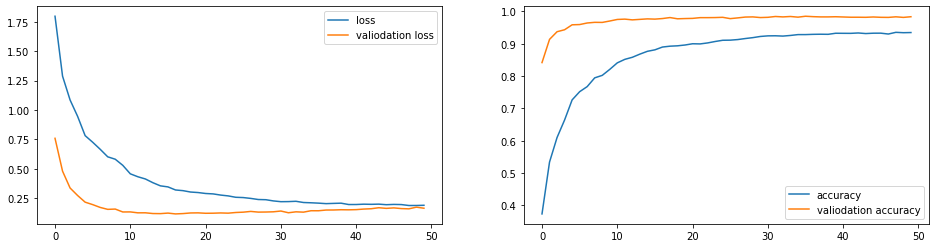

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='valiodation loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='valiodation accuracy')
axs[1].legend()

plt.show()

In [18]:
loaded_model = build_model()

In [19]:
loaded_model.load_weights('./model.h5')

## Validation

In [20]:
def predict(image: np.ndarray) -> str:
    prediction = loaded_model.predict(image)
    return TARGET_DECODER[np.argmax(prediction)]

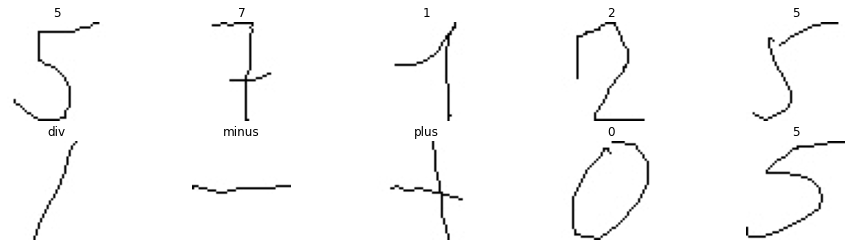

In [21]:
fig, axs = plt.subplots(2, 5, figsize=(16, 4))

for i in range(len(axs)):
    for j in range(len(axs[0])):
        r = random.randint(0, len(x_test))
        img = x_test[np.newaxis, r, :]

        axs[i][j].imshow(img[0, :, :, 0], cmap='gray')
        axs[i][j].set_title(predict(img))
        axs[i][j].axis('off')

## Validation from outside

In [22]:
outside_image = get_image_from_file('../outside-number.png')
outside_image = pre_processing(outside_image)

In [23]:
outside_image.shape

(45, 45, 1)

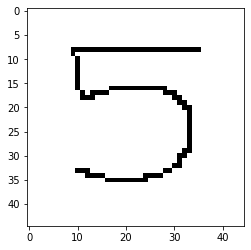

In [24]:
plt.imshow(outside_image[:, :], cmap='gray')

In [25]:
predict(outside_image[np.newaxis, :])

'5'